# Title 

## Modeling
---

In this notebook

### Table of content
---

- [Import Packages](#Import-Packages)
- [Preprocessing](#Preprocessing)
    - [New data frame](#New-data-frame) 
    - [New columns](#New-columns)
    - [Vaccination records](#Vaccination-records)  
        - [Population in Germany](#Population-in-Germany)
        - [First Dosage of vaccination](#First-Dosage-of-vaccination)
        - [Second Dosage of vaccination](#Second-Dosage-of-vaccination)
        - [Calculation of vaccination rate](#Calculation-of-vaccination-rate)
        - [Monthly vaccination rate](#Monthly-vaccination-rate)
- [ARIMA Model](#ARIMA-Model)
- [SARIMAX Model](#SARIMAX-Model)
        
    

### Import Packages 

In [1]:
#Import packages 
import pandas    as pd 
import numpy     as np
from datetime    import datetime

#Import Visualization tools 
import matplotlib.pyplot as plt
%matplotlib inline

#Import Skit-learn tools 
from sklearn.model_selection       import train_test_split
from sklearn.metrics               import mean_squared_error

#Import Statsmodel tools 
import statsmodels.api                    as sm
from statsmodels.graphics.tsaplots        import plot_acf, plot_pacf
from statsmodels.tsa.stattools            import adfuller
from statsmodels.tsa.statespace.sarimax   import SARIMAX
from statsmodels.tsa.arima_model          import ARIMA

#Import miscellaneous
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
register_matplotlib_converters()

### Preprocessing

In preprocessing we are going to use our raw data and transform it into an understandable format in order for us to use this data for Modeling.

In [3]:
#Reading in data set 
outbreak = pd.read_csv('../data/measles.csv')

#Converting time column into date time object
outbreak['time'] = pd.to_datetime(outbreak['time'])
outbreak.head()

,indicator,unit,time,regioncode,regionname,numvalue
0,Notification rate,N/1000000,1999-01-01,AT,Austria,250549.29
1,Notification rate,N/1000000,1999-01-01,DK,Denmark,188197.14
2,Notification rate,N/1000000,1999-01-01,EL,Greece,1581723.75
3,Notification rate,N/1000000,1999-01-01,FI,Finland,0.00
4,Notification rate,N/1000000,1999-01-01,IE,Ireland,1875666.86


In [4]:
print("The indicators in the data set are the followings: \n")
for indicator in outbreak['indicator'].unique(): 
    print(indicator)

The indicators in the data set are the followings: 

Notification rate 
Number of deaths
Reported cases
Reported confirmed cases
Vaccination coverage first dose
Vaccination coverage second dose


We are going to use `Reported confirmed cases` as our target variable and `Reported cases` and `Vaccination first and second dosage` as our features in predicting our target variable in our time series model. In order to utilize our data we need to create new data frames by filtering and creating new columns with these indicator and setting the time as index. 

#### New data frame

Filtering through target country for predictions

In [5]:
target_country = 'Germany'

Germany's data set during EDA has shown trends and seasonality, and seemed to be the best suited country for creating a time series models predicting measles outbreaks. 

In [6]:
#Creating a copy of data frame and filerting through regionname to obtain target country 
germany = outbreak.loc[outbreak['regionname'] == target_country].copy()

#Dropping columns that are not needed anymore 
germany.drop(columns=['unit', 'regioncode', 'regionname'], inplace=True)
germany.head()

,indicator,time,numvalue
240,Notification rate,2001-01-01,2674461.83
254,Notification rate,2001-02-01,5166573.99
268,Notification rate,2001-03-01,11877041.86
282,Notification rate,2001-04-01,15998144.40
296,Notification rate,2001-05-01,12825260.14


#### New columns 

##### Reported cases

In [7]:
#Filtering through Germany data frame to obtain reported cases
reported = germany.loc[germany['indicator'] == 'Reported cases'].copy()

#Checking if `time` column is unique, so it can be set as `index` column 
print(reported['time'].nunique() == reported.shape[0])

True


In [8]:
#Setting time as index 
reported.set_index('time', inplace=True)

#Dropping columns that are not needed 
reported.drop(columns=['indicator'], inplace=True)

##### Confirmed reported cases

In [9]:
#Filtering through indicator to get confirmed cases
confirmed = germany.loc[germany['indicator'] == 'Reported confirmed cases'].copy()

#Set time column as index
confirmed.set_index('time', inplace=True)

#Dropping columns that are not needed
confirmed.drop(columns=['indicator'], inplace=True)

##### Combining both data frames

In [10]:
#Merging both dataframes on time
df = reported.merge(confirmed, left_on='time', right_on='time')

In [11]:
#Renaming columns 
df.rename(columns={'numvalue_x': 'reported', 'numvalue_y': 'confirmed'}, inplace=True)
df.head()

,reported,confirmed
time,,
2001-01-01,220.0,73.0
2001-02-01,425.0,134.0
2001-03-01,977.0,335.0
2001-04-01,1316.0,466.0
2001-05-01,1055.0,443.0


#### Vaccination records 

Vaccination records are in percentage of population. In order to use this data, we need to convert percentage into the number of people in Germany, who are vaccinated. This can be done by using the population from Germany over time as population increased from 2001 to 2018. Additionally, our vaccination records are yearly. We need to impute the monthly rate from our yearly rate to match the rest of our time line. 

##### Population in Germany 
Creating a data frame with population from Germany. The information of population was obtained by this [resource](https://data.worldbank.org/indicator/SP.POP.TOTL?locations=DE).

In [12]:
#Population for Germany from 2001 to 2018 
population = {'2001': 82349925, 
              '2002': 82488495, 
              '2003': 82534176, 
              '2004': 82516260, 
              '2005': 82469422, 
              '2006': 82376451, 
              '2007': 82266372, 
              '2008': 82110097, 
              '2009': 81902307,
              '2010': 81776930,
              '2011': 80274983,
              '2012': 80425823,
              '2013': 80645605, 
              '2014': 80982500,
              '2015': 81686611, 
              '2016': 82348669,
              '2017': 82657002, 
              '2018': 82927922}

In [13]:
#Creating a data frame from dictionary 
germany_population = pd.DataFrame(list(population.items()), columns=['time', 'value'])

#Changing time column to date time object 
germany_population['time'] = pd.to_datetime(germany_population['time'])

#Resetting index column with time
germany_population.set_index('time', inplace= True)
germany_population.head()

,value
time,
2001-01-01,82349925
2002-01-01,82488495
2003-01-01,82534176
2004-01-01,82516260
2005-01-01,82469422


##### First Dosage of vaccination 

In [14]:
#Filtering for first dose of vaccination records 
vac_1 = germany.loc[germany['indicator'] == 'Vaccination coverage first dose'].copy()

#Dropping columns that is not needed anymore 
vac_1.drop(columns=['indicator'], inplace=True)
vac_1.head()

,time,numvalue
24721,1999-01-01,92.0
24751,2000-01-01,92.0
24781,2001-01-01,94.0
24811,2002-01-01,94.0
24841,2003-01-01,95.0


##### Second Dosage of vaccination 

In [15]:
#Filtering for second dose of vaccination records 
vac_2 = germany.loc[germany['indicator'] == 'Vaccination coverage second dose'].copy()

#Dropping columns that is not needed anymore 
vac_2.drop(columns=['indicator'], inplace=True)
vac_2.head()

,time,numvalue
25358,2002-01-01,77.0
25377,2003-01-01,83.0
25398,2004-01-01,89.0
25420,2005-01-01,91.0
25443,2006-01-01,90.0


Merging population data frame with vaccination record (1st dose and 2nd dose) 

In [16]:
vac_1 = vac_1.merge(germany_population, left_on='time', right_on='time')
vac_2 = vac_2.merge(germany_population, left_on='time', right_on='time')

##### Calculation of vaccination rate

The amount of vaccinated population in Germany can be calculated by multiplying the percentage of first/second dosage by the population during that time and dividing by 100.

In [17]:
#Calculating vaccination values 
vac_1['vaccine_1'] = vac_1['numvalue'] * vac_1['value'] / 100 
vac_2['vaccine_2'] = vac_2['numvalue'] * vac_2['value'] / 100 

#Combining first and second dosage data frame 
vaccine = vac_1.merge(vac_2, left_on='time', right_on='time', how='left')

#Dropping columns that are not needed 
vaccine.drop(columns=['numvalue_x', 'numvalue_y', 'value_x', 'value_y'], inplace=True)
vaccine.sort_values(by='time')

,time,vaccine_1,vaccine_2
0,2001-01-01,77408929.50,NaN
1,2002-01-01,77539185.30,63516141.15
2,2003-01-01,78407467.20,68503366.08
3,2004-01-01,79215609.60,73439471.40
4,2005-01-01,79170645.12,75047174.02
5,2006-01-01,79081392.96,74138805.90
6,2007-01-01,79798380.84,75685062.24
7,2008-01-01,79646794.09,75541289.24
8,2009-01-01,79445237.79,76169145.51
9,2010-01-01,79323622.10,76052544.90


**Observation:**

The data is missing values for 2001 in second dosage vaccination rate. After further research trying to find the missing value, it can be concluded that Germany did not report the second dosage vaccination rate for that specific year. ([Resource](https://www.ecdc.europa.eu/en/measles/surveillance-and-disease-data/annual-surveillance-data))

##### Monthly vaccination rate 

Our reported and confirmed outbreak cases are monthly, however, vaccination rate is yearly. We need to convert the vaccination rate from yearly into a monthly rate.

Creating a new data frame with Time range from 2001 to 2018

In [18]:
#Monthly date range from 2001 to 2018 
time = pd.date_range(start='1/1/2001', end='12/1/2018', freq='MS')

#Empty data frame 
vaccine_value = pd.DataFrame(index=time, data=vaccine, columns=['vaccine_1', 'vaccine_2'])
vaccine_value.head()

,vaccine_1,vaccine_2
2001-01-01,NaN,NaN
2001-02-01,NaN,NaN
2001-03-01,NaN,NaN
2001-04-01,NaN,NaN
2001-05-01,NaN,NaN


Using data frame `vaccine` with yearly records to impute values in the monthly records of vaccination in `vaccine_value`

In [19]:
#Iterating through each row of vaccine(monthly)
for index_1, time in enumerate(vaccine_value.index):
    
    #Iterating through each row of vaccine(yearly)
    for index, time_2 in enumerate(vaccine['time']):
        
        #Comparing years 
        if time.year == time_2.year:
            
            #Imputing values from yearly to monthly 
            vaccine_value['vaccine_1'][index_1] = vaccine['vaccine_1'][index]
            vaccine_value['vaccine_2'][index_1] = vaccine['vaccine_2'][index]

In [20]:
vaccine_value

,vaccine_1,vaccine_2
2001-01-01,77408929.50,NaN
2001-02-01,77408929.50,NaN
2001-03-01,77408929.50,NaN
2001-04-01,77408929.50,NaN
2001-05-01,77408929.50,NaN
...,...,...
2018-08-01,80440084.34,77122967.46
2018-09-01,80440084.34,77122967.46
2018-10-01,80440084.34,77122967.46
2018-11-01,80440084.34,77122967.46


In [21]:
#Joining outbreaks and vaccination data frames 
df = df.join(vaccine_value)

#Dropping NaN's
df.dropna(inplace=True)
df.head()

,reported,confirmed,vaccine_1,vaccine_2
time,,,,
2002-01-01,815.0,117.0,77539185.3,63516141.15
2002-02-01,994.0,125.0,77539185.3,63516141.15
2002-03-01,916.0,127.0,77539185.3,63516141.15
2002-04-01,585.0,137.0,77539185.3,63516141.15
2002-05-01,520.0,101.0,77539185.3,63516141.15


Plotting Measles cases and vaccination rate from Germany

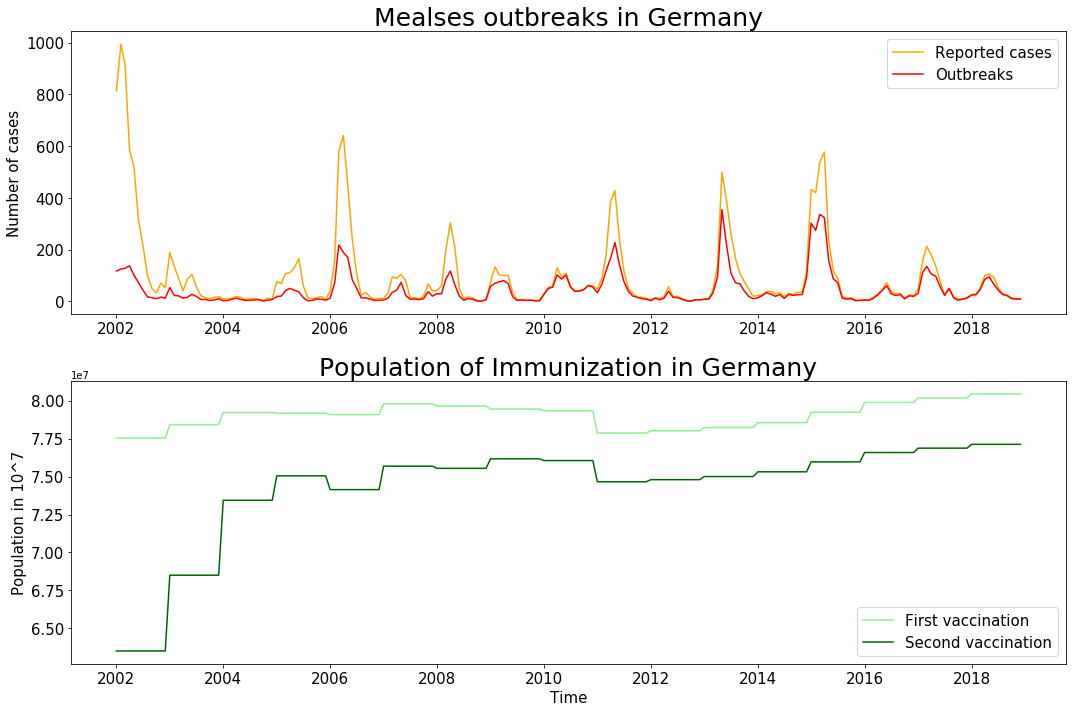

In [22]:
#Creating subplots
f, axes = plt.subplots(2, 1, figsize=(15,10))

#Plotting outbreaks
axes[0].plot(df.index, df['reported'], label= 'Reported cases', color='orange')
axes[0].plot(df.index, df['confirmed'], label= 'Outbreaks', color='red')

#Setting labels, legend and sizes
axes[0].set_ylabel('Number of cases', fontsize=15)
axes[0].legend(fontsize=15)
axes[0].tick_params(labelsize=15)
axes[0].set_title("Mealses outbreaks in Germany", fontsize=25)

#Plotting vaccination 
axes[1].plot(df.index, df['vaccine_1'], label= 'First vaccination', color='lightgreen')
axes[1].plot(df.index, df['vaccine_2'], label= 'Second vaccination', color='darkgreen')

#Setting labels, legend and sizes
axes[1].set_ylabel('Population in 10^7', fontsize=15)
axes[1].set_xlabel('Time', fontsize=15)
axes[1].legend(loc='lower right', fontsize=15)
axes[1].tick_params(labelsize=15)
axes[1].set_title("Population of Immunization in Germany", fontsize=25)

plt.tight_layout(pad=1.08, h_pad=2);


### ARIMA Model

An ARIMA model stands for _AutoRegressive_, _Integrated_, _Moving Average_ models and is very useful and flexible model that can be used for most time series models.

In order to fit an ARIMA model, we need to specify three parameters:
- $p$, the autoregressive part 
- $d$, also known as the differencing parameter, which is our Integrated part 
- $q$, the moving average part

Our target variable is confirmed reported cases from Germany

In [23]:
df[['confirmed']].head()

,confirmed
time,
2002-01-01,117.0
2002-02-01,125.0
2002-03-01,127.0
2002-04-01,137.0
2002-05-01,101.0


#### Differencing Parameter 

$d$, as already mentioned is the differencing parameter in ARIMA models and it controls how much we "difference" our time series by. Differencing our time series means that instead of fitting a model that predicts our time series $Y_t$ directly, we'll fit a model to $Y'_t$ or $Y''_t$. There is one assumption that is **required** for nearly every time series model, which is known as **stationarity**. Stationarity means that there are no systematic changes in our time series over time, which basically means that the mean stays the same (no trends) and the autocorrelation between $Y_t$ and $Y_{t-k}$ depends only on the size of our lag $k$. (There is no seasonality.)

We can check for Stationarity with the Augmented Dickey-Fuller Test, which is a hypothesis test that tests for stationarity. Specifically, the tests follows: 

$$
\begin{eqnarray}
&H_0:& \text{not stationary} \\
&H_A:& \text{stationary}
\end{eqnarray}
$$

A small $p$-value would give us evidence to reject the null hypothesis, meaning we accept that our time series is stationary.



In [24]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [25]:
#Checking for Stationarity
interpret_dftest(adfuller(df['confirmed']))

Test Statistic   -6.532269e+00
p-value           9.802733e-09
dtype: float64

With a $p$ -value of well below 0.05, we can reject $H_0$  and thus accept that our data is already stationary.

#### Autoregressive Parameter 

The autoregressive piece (`AR`) of our ARIMA model is usually responsible for modeling the long-term trends in our time series and does not handle sudden shocks well. The autoregressive piece of our ARIMA model will learn regression coefficients on the features that are the previous $p$ values. 
- An $AR(p)$ piece includes $p$ prior values: $\beta_0 + \sum_{k=1}^p \beta_kY_{t-k}$

Using Autocorrelation plot an Partial autocorrelation plot the $p$ parameter can be determined

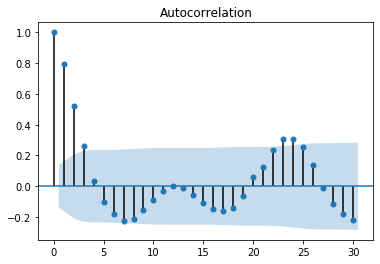

In [26]:
#ACF plot with 30 lags
plot_acf(df['confirmed'], lags=30);

**Observation:**  
Autocorrelation plot above shows that observations are highly correlated with one another. For this plot, 1 time lag apart has a correlation around 0.8. Observation outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$. 
Therefore, there is a statistically significant correlation between $Y_t$ and $Y_{t-k}$ for $k$ = 1, 2, 3, 23, 24

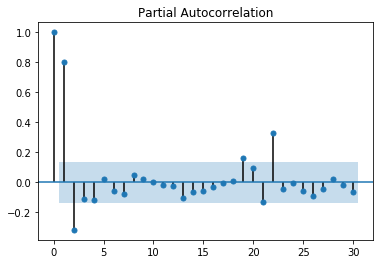

In [27]:
#PACF plot with 30 lags
plot_pacf(df['confirmed'], lags = 30);

**Observation:** 

The partial autocorrelation plot above shows that observations are highly correlated with one another. However, the partial autocorrelation plot checks for the correlation between observations, conditioning on all lower-lag autocorrelations. That means that the partial autocorrelation between $Y_t$ and $Y_{t-2}$ is the correlation between $Y_t$ and $Y_{t-2}$ that has already taken into account the autocorrelation between $Y_t$ and $Y_{t-1}$. Like previously with ACF plot, the blue band indicates the 95% confidence interval for these correlations.

Observations outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$ = 2, 22.

If the PACF has a sharp cut-off and the lag-1 PACF value is positive,  we can choose $p$ to be the lag in the PACF before the cut-off.
- Therefore, $p=1$ 



#### Moving Average Parameter

In the moving average piece, we take **previous error terms** as inputs. They predict the next value based on deviations from previous predictions. The moving average piece does handle sudden, random shocks well and $q$ indicates the number of previous errors to incorporate.

- An $MA(q)$ piece includes $q$ prior values: $\mu + \sum_{k=1}^q w_k\varepsilon_{t-k}$

We can determine $q$ based on ACF plot. 

> "If the ACF has a sharp cut-off and the lag-1 ACF value is negative, start at lag 0, and move from left to right until you find the first non-significant value, then back up one and select that value of $q$. (By Aurelia Lyon from DSI-8 Seattle)

The ACF plot does not have a sharp cut-off or the lag-1 ACF value is not negative, then we let our $q=0$.

Additionally, we can use our X-variables to forecast our y-variable. However, we should lag our $X$ variables by at least one time point. 

In [28]:
#Creating new columns with 1-lag 
df['reported_lag_1'] = df['reported'].shift(1)
df['vaccine_1_lag_1'] = df['vaccine_1'].shift(1)
df['vaccine_2_lag_1'] = df['vaccine_2'].shift(1)

In [29]:
features = ['reported_lag_1', 'vaccine_1_lag_1', 'vaccine_2_lag_1']
X = df[features]
y = df['confirmed']

In [30]:
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    shuffle = False,
                                                    random_state=123) 

In [31]:
print(f" y_train shape = {y_train.shape}")
print(f" y_test shape = {y_test.shape}")
print(f" Time from y_test starts with {y_test.index[0].date()} till {y_test.index[-1].date()}")


 y_train shape = (142,)
 y_test shape = (62,)
 Time from y_test starts with 2013-11-01 till 2018-12-01


In [40]:
#Instantiating ARIMA model.
model = ARIMA(endog = y_train.astype(float).dropna(),
                      #(p, d, q)
              order = (1, 0 ,0) ) 
#Fitting model.
arima_1_0_0 = model.fit() 

#Generateing predictions.
preds = model.predict(params = arima_1_0_0.params,
                      start =  datetime(2013,11,1),
                      end =    datetime(2018,12,1))

/Users/preeya/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Function to plot predictions

In [47]:
def plotting_predictions(y_train, y_test, preds, title = None, title_size = 24, ticks_size = 20, legend_size = 20):

    #Plotting data.
    plt.figure(figsize=(17,10))

    #Plotting training data.
    plt.plot(y_train, color = 'blue', label= 'Training set')

    #Plotting testing data.
    plt.plot(y_test, color = 'orange', label = 'Testing set')

    #Plotting predicted test values.
    plt.plot(y_test.index, preds, color = 'red', label = 'Predictions')

    #Setting label, ticksmarks and legend
    plt.title(label = title, fontsize=title_size)
    plt.tick_params(labelsize=ticks_size)
    plt.legend(fontsize=legend_size )

    #Evaluating these predictions using MSE.
    print(f"Mean Square Error = {mean_squared_error(y_test,preds)}");

Mean Square Error = 5781.682575636401


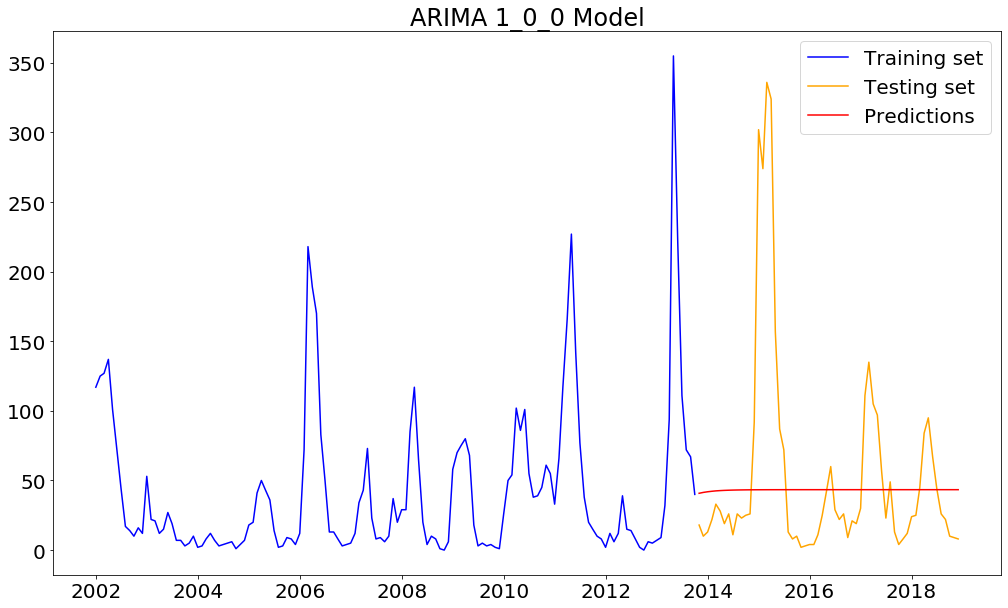

In [49]:
#Plotting ARIMA 1_0_0 Model 
plotting_predictions(y_train, y_test, preds, "ARIMA 1_0_0 Model")

**Observation**: As we can see using just an ARIMA model is not great for our predictions. The predictions came out almost as a straight-line, we can continue with fitting a seasonal ARIMA (SARIMA) model to our data. This way we can include seasonal components that will allow us to also account for seasonality that occurs over time.

### SARIMAX Model

The SARIMA model is given by $ARIMA(p, d, q) × (P, D, Q, S)$, where:
- $ARIMA(p, d, q)$ is the ARIMA model we've already discussed with AR order $p$, MA order $q$, and differencing order $d$.
- $(P, D, Q, S)$ refers to the seasonal AR order $P$, the seasonal MA order $Q$, the seasonal differencing order $D$, and the length of the season $S$.
- In order to **rigorously** fit a seasonal model, specify $S$ that appears to make sense.
    - Here, we might try 12.
        - In looking at the ACF plot, there's a clear seasonal trend that peaks every 12 months.
        - There are 12 months in a year, which makes even more sense that we'd see bus ridership fluctuate on a yearly pattern.
    - Then find the values of $P$, $D$, and $Q$ by looking at the ACF/PACF plot, but skipping by values of $S$. (i.e. if $S=12$, then check out the ACF and PACF plots 12 steps apart from one another.)
- In order to more realistically fit a seasonal model... GridSearch!

# eXogenous Predictors

In time series analysis, we spend most of our time focused on how we can quantify the relationship between $Y_t$ and $Y_{t-k}$ and then use that relationship to forecast values of $Y_t$.

Future bus ridership probably isn't limited to just past performance of bus ridership. 

However, we can (and should!) still use $X$ variables in our data.
- In `statsmodels` and in various disciplines like econometrics, the $X$ variables are known as `exogenous`.
- More on exogenous/endogenous [here](http://www.statsmodels.org/stable/endog_exog.html).

In fact, the SARIMAX model stands for "Seasonal Autoregressive Integrated Moving Average with eXogenous regressors model."

#### One important practical note: 
If you're going to fit a SARIMAX model, make sure that your $X$ variable makes sense - especially timewise.
> For example, if we want to forecast bus ridership for December 2018 based on precipitation, I probably shouldn't use December 2018 precipitation as an input. (I'm forecasting a value of $Y$ when I wouldn't have access to that value of $X$!)

I should probably lag my $X$ variable by at least one time point. 

In [50]:
# Fit a SARIMA(1, 0, 1) x (1, 0, 0, 12) model.

sarima = SARIMAX(endog = y_train,
                 order = (1, 0, 1),              # (p, d, q)
                 seasonal_order = (1, 0, 0, 12)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=datetime(2013,11,1),
                      end=datetime(2018,12,1))

/Users/preeya/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Mean Square Error = 7923.643074268617


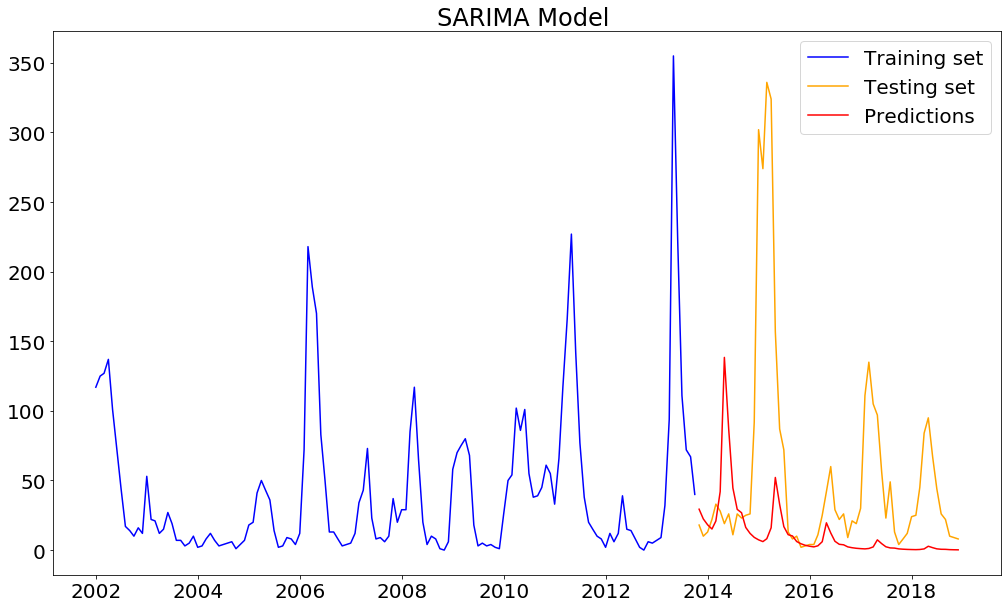

In [52]:
plotting_predictions(y_train, y_test, preds, title= "SARIMA Model ")

/Users/preeya/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/preeya/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Mean Square Error = 3071.409258534331


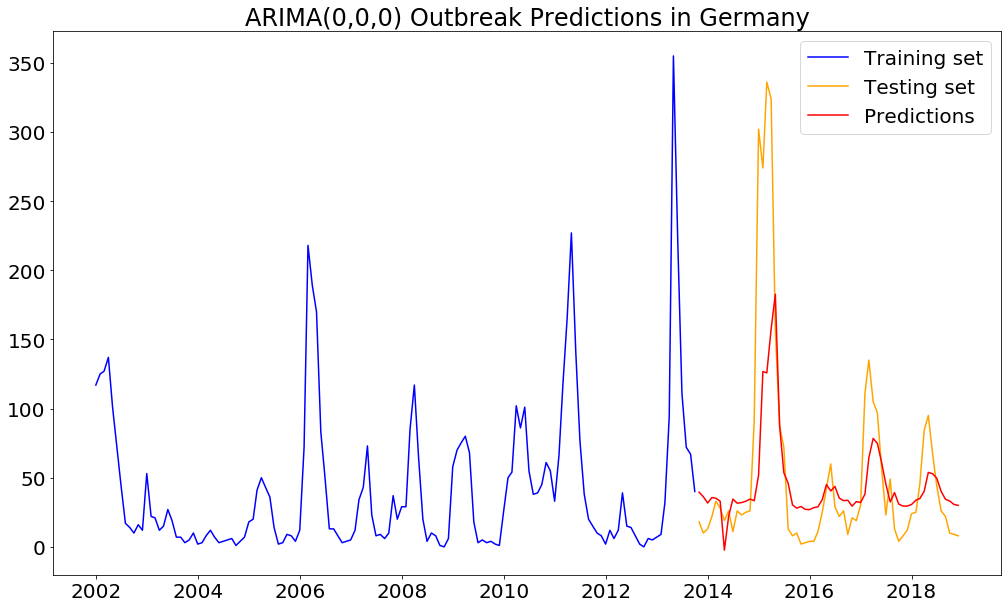

In [53]:
# Fit a SARIMAX(0, 2, 1) x (0, 0, 1, 12) model.

sarima = SARIMAX(endog = y_train[1:],
                 order = (1, 0, 0),              # (p, d, q)
                 seasonal_order = (1, 0, 2, 12), # (P, D, Q, S)
                 exog = X_train.dropna()) 

# Fit SARIMAX model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start=datetime(2013,11,1),
                      end=datetime(2018,12,1),
                      exog=X_test.dropna())

#Plotting data.
plt.figure(figsize=(17,10))

#Plotting training data.
plt.plot(y_train, color = 'blue', label= 'Training set')

#Plotting testing data.
plt.plot(y_test, color = 'orange', label = 'Testing set')

#Plotting predicted test values.
plt.plot(y_test.index, preds, color = 'red', label = 'Predictions')

#Setting label, ticksmarks and legend
plt.title(label = 'ARIMA(0,0,0) Outbreak Predictions in Germany', fontsize=24)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)

#Evaluating these predictions using MSE.
print(f"Mean Square Error = {mean_squared_error(y_test,preds)}");

```python
###### Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(3):
            for S in range(0,13,4):
                try:
                    print(f'Attempting to fit SARIMAX(1,0,1)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = y_train[1:],
                                     order = (1, 0, 1),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                     exog = X_train.dropna()) 
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=datetime(2013,11,1),
                                          end=datetime(2018,12,1),
                                          exog=X_test.dropna())

                    # Evaluate predictions.
                    print(f'The MSE for (1, 0, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(y_test, preds):
                        best_mse = mean_squared_error(y_test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(1, 0, 1)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')
```